# [course website](https://dev.mrdbourke.com/tensorflow-deep-learning/03_convolutional_neural_networks_in_tensorflow/)

## Libraries

In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
import random
import zipfile
import os
import pathlib

## Functions

In [ ]:
def get_random_img(target_dir, target_class, seed=-1, verbose=1):
  if seed >= 0:
    random.seed(seed)

  target_folder = (target_dir+'/' if target_dir[-1]!='/' else target_dir) + target_class
  random_img_path = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder+'/'+random_img_path[0])

  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  if verbose:
    print(f'Image shape: {img.shape}')
    print(f'Image name: {random_img_path}')
  return img

In [ ]:
def plot_loss_curves(histories):
  if len(histories) > 1:
    plt.figure(figsize=(5*len(histories), 10))
    figure, axis = plt.subplots(2, len(histories))
    figure.suptitle('Models comparison\n', fontweight ="bold")
    for x, history in enumerate(histories):
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      axis[0, x].plot(epochs, loss, label='training_loss')
      axis[0, x].plot(epochs, val_loss, label='val_loss')
      axis[0, x].set_title(f'Loss m{x}')
      if x==0:
        axis[0, x].tick_params(bottom = False, labelbottom = False)
        axis[0, x].legend()
      else:
        axis[0, x].tick_params(left = False, right = False, labelleft = False,
                labelbottom = False, bottom = False)

      axis[1, x].plot(epochs, accuracy, label='training_accuracy')
      axis[1, x].plot(epochs, val_accuracy, label='val_accuracy')
      axis[1, x].set_title(f'Accuracy m{x}')
      if x==0:
        axis[1, x].set_xlabel('Epochs')
        axis[1, x].legend()
      else:
        axis[1, x].tick_params(left = False, right = False, labelleft = False)
  else:
    history = histories[0]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
def diffrent_data_comparison(data_x, data_y, title_x='DataX', title_y='DataY', batch_size=32, seed=-1):
  if seed >= 0:
    random.seed(seed)

  images_x, labels_x = data_x.next()
  images_y, labels_y = data_y.next()

  rand_num = random.randint(0, batch_size)

  plt.figure()
  plt.imshow(images_x[rand_num])
  plt.title(title_x)
  plt.axis(False)

  plt.figure()
  plt.imshow(images_y[rand_num])
  plt.title(title_y)
  plt.axis(False);

In [ ]:
def predict_img(model, filename, class_names, img_shape=224, verbose=1):
  img = tf.io.read_file(filename)
  # decode and resize
  img = tf.image.resize(tf.image.decode_jpeg(img, channels=3), size=[img_shape, img_shape])
  # normalize
  img = img/255.

  # visualise
  prediction_prabability = model.predict(tf.expand_dims(img, axis=0))
  if len(prediction_prabability[0]) > 1:
    pred_class = class_names[tf.argmax(*prediction_prabability)]
  else:
    pred_class = class_names[int(tf.round(prediction_prabability))]

  if verbose>=0:
    print(f'{pred_class}: {prediction_prabability}')
  # plot
  raw_img = mpimg.imread(filename)
  plt.imshow(raw_img)
  plt.axis(False)
  plt.title(f'Prediction: {pred_class}')

# Binary image classification

## Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-06-15 19:58:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   235MB/s    in 0.4s    

2023-06-15 19:58:07 (235 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
!ls pizza_steak
!ls pizza_steak/train/
!ls pizza_steak/train/pizza

test  train
pizza  steak
1008104.jpg  1638227.jpg  2235981.jpg  2774899.jpg  3464027.jpg  576236.jpg
1008144.jpg  1646974.jpg  2236914.jpg  2775763.jpg  3464858.jpg  5764.jpg
1008844.jpg  1649108.jpg  2241448.jpg  2778214.jpg  3473991.jpg  579691.jpg
1008941.jpg  1649276.jpg  2247711.jpg  277963.jpg   3475936.jpg  593400.jpg
1011404.jpg  1652943.jpg  2253670.jpg  2785084.jpg  3478964.jpg  59445.jpg
102037.jpg   1654444.jpg  2255361.jpg  2793535.jpg  3479875.jpg  596494.jpg
1026922.jpg  1660415.jpg  2274117.jpg  27963.jpg    3479936.jpg  598381.jpg
1029698.jpg  1663749.jpg  2279642.jpg  2800325.jpg  3484590.jpg  604977.jpg
1033251.jpg  1665654.jpg  2280345.jpg  2811032.jpg  3493457.jpg  608085.jpg
1035854.jpg  166823.jpg   2285269.jpg  282013.jpg   349946.jpg	 618021.jpg
1038357.jpg  1670471.jpg  2285942.jpg  2821034.jpg  350358.jpg	 61822.jpg
1040878.jpg  1671531.jpg  228778.jpg   2821048.jpg  3505182.jpg  618348.jpg
1044524.jpg  1678284.jpg  2291093.jpg  2827938.jpg  3512070.jpg  6256

In [ ]:
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [ ]:
num_steak_img_train = len(os.listdir('pizza_steak/train/steak'))
num_steak_img_train

750

In [ ]:
data_dir = pathlib.Path('pizza_steak/train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


Image shape: (384, 512, 3)
Image name: ['1055065.jpg']


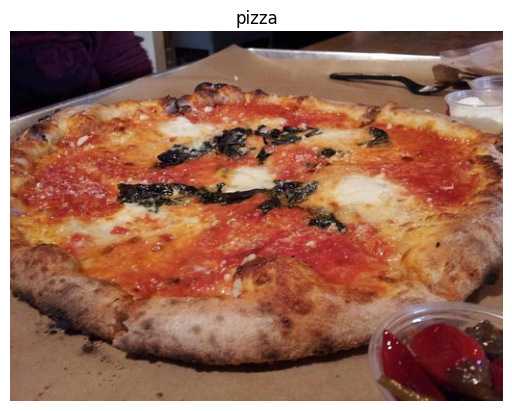

In [ ]:
img = get_random_img('pizza_steak/train', 'pizza', seed=42, verbose=1)

In [ ]:
tf.constant(img)

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 10,   7,  24],
        [ 10,   8,  22],
        [ 11,   9,  23],
        ...,
        [ 57,  33,  23],
        [ 57,  33,  23],
        [ 55,  31,  19]],

       [[  7,   4,  21],
        [  7,   3,  20],
        [  8,   4,  19],
        ...,
        [ 61,  37,  27],
        [ 61,  37,  27],
        [ 59,  35,  25]],

       [[ 10,   3,  21],
        [  9,   2,  20],
        [  9,   2,  18],
        ...,
        [ 65,  40,  33],
        [ 65,  40,  33],
        [ 64,  39,  32]],

       ...,

       [[140, 103,  84],
        [142, 105,  86],
        [144, 107,  88],
        ...,
        [ 55,  24,  22],
        [ 54,  23,  21],
        [ 54,  22,  23]],

       [[141, 104,  85],
        [141, 104,  85],
        [142, 105,  86],
        ...,
        [ 58,  24,  22],
        [ 58,  24,  23],
        [ 58,  24,  23]],

       [[141, 104,  85],
        [139, 102,  83],
        [138, 101,  82],
        ...,
        [ 60,  25,  2

In [ ]:
tf.random.set_seed(42)

# normalize data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# set paths to data
train_dir = '/content/pizza_steak/train'
test_dir = 'pizza_steak/test'

# import data and batch it
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

train_batch_ammount = len(train_data)
valid_batch_ammount = len(valid_data)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Model_1 - basic CNN structure

In [ ]:
model_1 = tf.keras.Sequential()

model_1.add(
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        activation='relu',
        input_shape=(224, 224, 3)
    )
)
model_1.add(tf.keras.layers.Conv2D(10, 3, activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation='relu'))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation='relu'))
model_1.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

hist_m1 = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=train_batch_ammount,
    validation_data=valid_data,
    validation_steps=valid_batch_ammount
)

Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.6833

47/47 [==============================] - 19s 293ms/step - loss: 0.5821 - accuracy: 0.6833 - val_loss: 0.4543 - val_accuracy: 0.8160
Epoch 2/5
47/47 [==============================] - 9s 199ms/step - loss: 0.4509 - accuracy: 0.7940
Epoch 3/5
47/47 [==============================] - 10s 206ms/step - loss: 0.4098 - accuracy: 0.8287
Epoch 4/5
47/47 [==============================] - 10s 216ms/step - loss: 0.3711 - accuracy: 0.8487
Epoch 5/5
47/47 [==============================] - 9s 193ms/step - loss: 0.3118 - accuracy: 0.8753


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
loss, accuracy = model_1.evaluate(valid_data, verbose=0)
name = 'model_1'
print('+' + '-'*30 + '+')
print('|' + ' '*(7-len(str(name))//2) + 'MODEL ' + str(name) + ' EVALUATION' + ' '*(6-len(str(name))//2 - (len(str(name))%2)*1) + '|')
print('|' + '.'*30 + '|')
print('|' + ' '*2 + 'Loss: ' + str(loss) + ' '*(28-len('Loss: ' + str(loss))) + '|')
print('|' + ' '*1 + 'Accuracy: ' + str(accuracy) + ' '*(26-len('Loss: ' + str(loss))) + '|')
print('+' + '-'*30 + '+')
print()

+------------------------------+
|    MODEL model_1 EVALUATION  |
|..............................|
|  Loss: 0.35889217257499695   |
| Accuracy: 0.8500000238418579 |
+------------------------------+



Image shape: (512, 384, 3)
Image name: ['23199.jpg']
Image shape: (384, 512, 3)
Image name: ['477486.jpg']


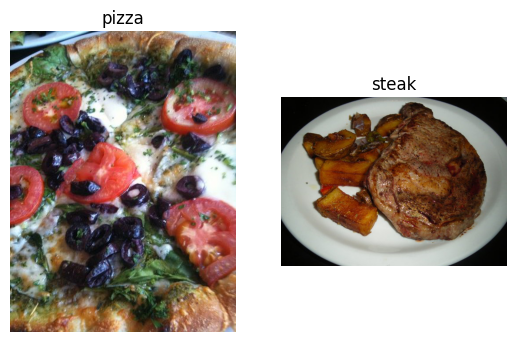

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
pizza_img = get_random_img('pizza_steak/train', 'pizza', verbose=1)
plt.subplot(1, 2, 2)
steak_img = get_random_img('pizza_steak/train', 'steak', verbose=1)

## Data redone - steps explained

In [ ]:
# dirs
test_dir = 'pizza_steak/test'
train_dir = 'pizza_steak/train'

In [ ]:
# image transformer
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# loading to batches and transforming images
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='binary',
    seed=42
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# amount of batches for botch data types
train_batch_ammount = len(train_data)
valid_batch_ammount = len(valid_data)

In [ ]:
# check the batches
images, labels = train_data.next()

In [ ]:
# size of batch
len(images), len(labels)

(32, 32)

In [ ]:
# check the image data
# data is normalized and batched
images[:2][0][0][0], images.shape

(array([0.42352945, 0.43137258, 0.34509805], dtype=float32), (32, 224, 224, 3))

In [ ]:
# true labels
labels

array([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

## Model_2 - steps explained

In [ ]:
model_2 = Sequential([
  Conv2D(filters=10,
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu',
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

In [ ]:
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
hist_m2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=train_batch_ammount,
                        validation_data=valid_data,
                        validation_steps=valid_batch_ammount)

Epoch 1/5
47/47 [==============================] - 15s 277ms/step - loss: 0.6534 - accuracy: 0.7400 - val_loss: 0.3988 - val_accuracy: 0.8120
Epoch 2/5
47/47 [==============================] - 14s 306ms/step - loss: 0.3871 - accuracy: 0.8280 - val_loss: 0.3742 - val_accuracy: 0.8500
Epoch 3/5
47/47 [==============================] - 14s 290ms/step - loss: 0.2561 - accuracy: 0.9073 - val_loss: 0.4801 - val_accuracy: 0.7880
Epoch 4/5
47/47 [==============================] - 12s 259ms/step - loss: 0.1280 - accuracy: 0.9600 - val_loss: 0.4235 - val_accuracy: 0.8060
Epoch 5/5
47/47 [==============================] - 12s 263ms/step - loss: 0.0309 - accuracy: 0.9967 - val_loss: 0.7726 - val_accuracy: 0.7660


<Axes: >

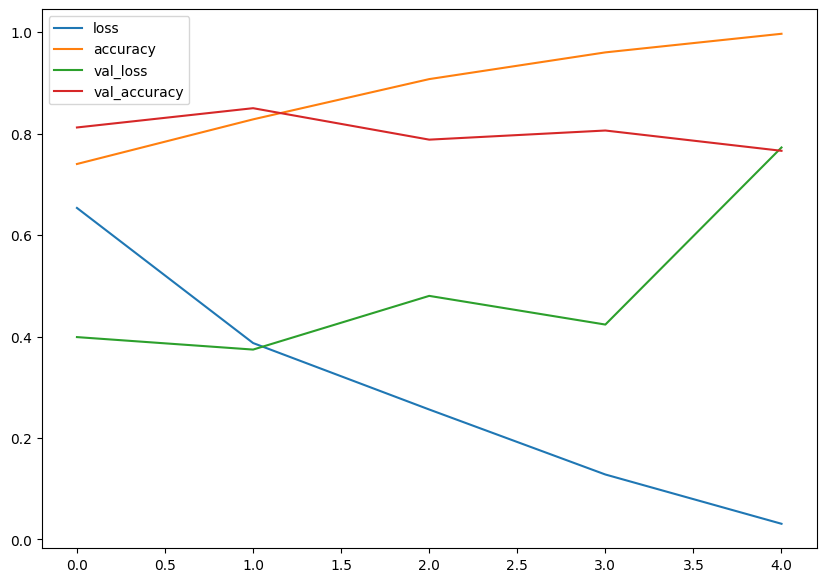

In [ ]:
# evaluate
pd.DataFrame(hist_m2.history).plot(figsize=(10, 7))

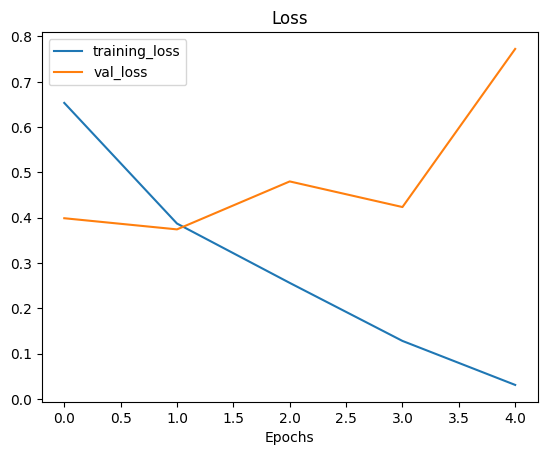

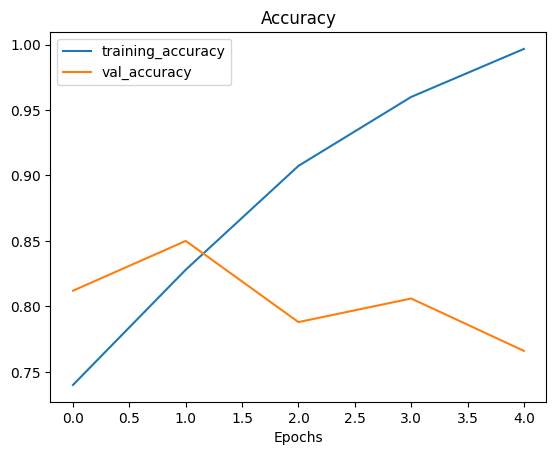

In [ ]:
# model is overfitting
plot_loss_curves([hist_m2])

## Reducing overfitting

### Model_3 - Using MaxPool2D

In [ ]:
# MaxPool2D() reduces details by getting max value of near pixels to all of them to reduce overfitt
model_3 = Sequential([
  Conv2D(filters=10,
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu',
         input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
hist_m3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=train_batch_ammount,
                        validation_data=valid_data,
                        validation_steps=valid_batch_ammount)

Epoch 1/5
47/47 [==============================] - 14s 261ms/step - loss: 0.6221 - accuracy: 0.6587 - val_loss: 0.4985 - val_accuracy: 0.7820
Epoch 2/5
47/47 [==============================] - 11s 241ms/step - loss: 0.4710 - accuracy: 0.7987 - val_loss: 0.4130 - val_accuracy: 0.8200
Epoch 3/5
47/47 [==============================] - 12s 246ms/step - loss: 0.4284 - accuracy: 0.8073 - val_loss: 0.3743 - val_accuracy: 0.8200
Epoch 4/5
47/47 [==============================] - 12s 247ms/step - loss: 0.4311 - accuracy: 0.8033 - val_loss: 0.3522 - val_accuracy: 0.8600
Epoch 5/5
47/47 [==============================] - 12s 251ms/step - loss: 0.3807 - accuracy: 0.8413 - val_loss: 0.3350 - val_accuracy: 0.8500


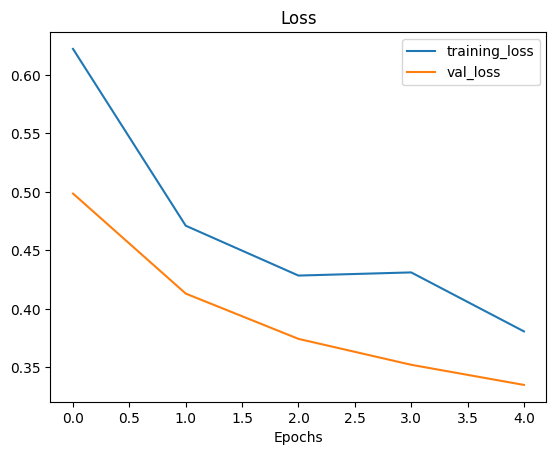

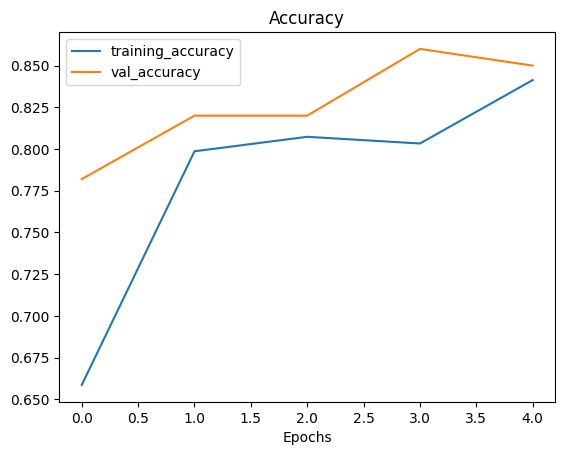

In [ ]:
plot_loss_curves([hist_m3])

### data redone with augmentation

In [ ]:
# disturb the image to make it less obvious and generalize the look
train_datagen_augmented = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
    shear_range=0.2, # shear the image
    zoom_range=0.2, # zoom into the image
    width_shift_range=0.2, # shift the image width ways
    height_shift_range=0.2, # shift the image height ways
    horizontal_flip=True # flip the image on the horizontal axis
)

In [ ]:
# rescale to normalize
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data
train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

# test images don't need augmentations as they are simulating real life examples
test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
train_augmented_batch_ammount = len(train_data_augmented)
train_batch_ammount = len(train_data)
valid_batch_ammount = len(valid_data)

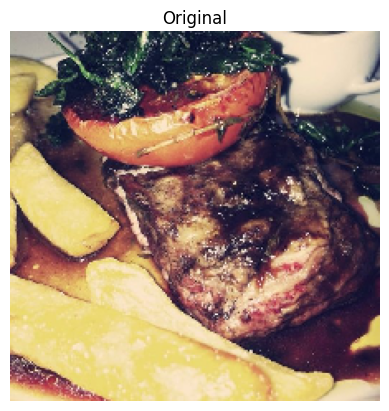

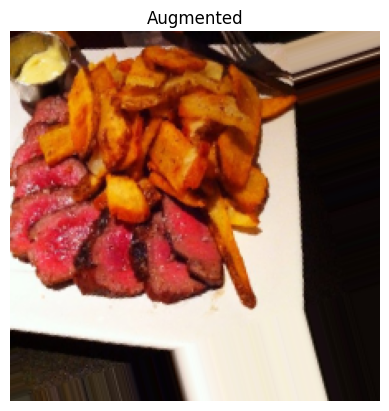

In [ ]:
diffrent_data_comparison(train_data, train_data_augmented, 'Original', 'Augmented', seed=3)

### Model_4 - Using augmented data

In [ ]:
model_4 = Sequential([
  Conv2D(filters=10,
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu',
         input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
hist_m4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=train_augmented_batch_ammount,
                        validation_data=valid_data,
                        validation_steps=valid_batch_ammount)

Epoch 1/5
47/47 [==============================] - 17s 298ms/step - loss: 1.0925 - accuracy: 0.6160 - val_loss: 0.4874 - val_accuracy: 0.7480
Epoch 2/5
47/47 [==============================] - 12s 257ms/step - loss: 0.4621 - accuracy: 0.7900 - val_loss: 0.3743 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 12s 262ms/step - loss: 0.3942 - accuracy: 0.8287 - val_loss: 0.3763 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 12s 262ms/step - loss: 0.2773 - accuracy: 0.8980 - val_loss: 0.4143 - val_accuracy: 0.8060
Epoch 5/5
47/47 [==============================] - 12s 262ms/step - loss: 0.1467 - accuracy: 0.9560 - val_loss: 0.4345 - val_accuracy: 0.8280


### Model_5 - combined methods

In [ ]:
model_5 = Sequential([
  Conv2D(filters=10,
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu',
         input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
hist_m5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=train_augmented_batch_ammount,
                        validation_data=valid_data,
                        validation_steps=valid_batch_ammount)

Epoch 1/5
47/47 [==============================] - 16s 293ms/step - loss: 0.6307 - accuracy: 0.6327 - val_loss: 0.5697 - val_accuracy: 0.6480
Epoch 2/5
47/47 [==============================] - 20s 428ms/step - loss: 0.5027 - accuracy: 0.7647 - val_loss: 0.4047 - val_accuracy: 0.8500
Epoch 3/5
47/47 [==============================] - 12s 266ms/step - loss: 0.4317 - accuracy: 0.8153 - val_loss: 0.3611 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 12s 252ms/step - loss: 0.4020 - accuracy: 0.8267 - val_loss: 0.3493 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 11s 246ms/step - loss: 0.3930 - accuracy: 0.8293 - val_loss: 0.3376 - val_accuracy: 0.8680


## Model_6 - review and combining methods to make best model

In [ ]:
model_6 = Sequential([
  Conv2D(filters=32, # more filters
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu',
         input_shape=(224, 224, 3)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
hist_m6 = model_6.fit(train_data,
                        epochs=5,
                        steps_per_epoch=train_augmented_batch_ammount,
                        validation_data=valid_data,
                        validation_steps=valid_batch_ammount)

Epoch 1/5
47/47 [==============================] - 32s 292ms/step - loss: 0.6420 - accuracy: 0.6073 - val_loss: 0.4900 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 11s 224ms/step - loss: 0.5208 - accuracy: 0.7453 - val_loss: 0.4485 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 11s 231ms/step - loss: 0.4775 - accuracy: 0.7787 - val_loss: 0.4264 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 12s 253ms/step - loss: 0.4533 - accuracy: 0.7993 - val_loss: 0.3630 - val_accuracy: 0.8460
Epoch 5/5
47/47 [==============================] - 11s 229ms/step - loss: 0.4238 - accuracy: 0.8167 - val_loss: 0.3722 - val_accuracy: 0.8560


## summary of all models

<Figure size 2500x1000 with 0 Axes>

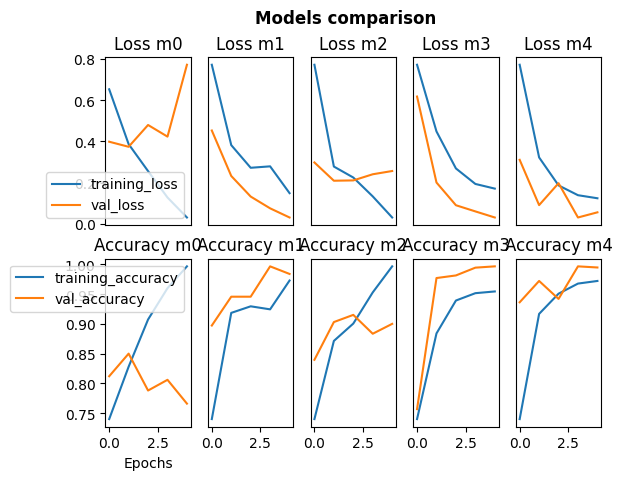

In [ ]:
plot_loss_curves([hist_m2, hist_m3, hist_m4, hist_m5, hist_m6])

## Predicting new data on trained model

In [ ]:
# get imgs from github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://www.google.com/imgres?imgurl=https%3A%2F%2Ffreepngimg.com%2Fconvert-png%2F35510-pepperoni-pizza&tbnid=aWDQOLllxw3GMM&vet=12ahUKEwjq5-_bkMb_AhVwkIsKHYLaCXQQMygDegUIARDCAQ..i&imgrefurl=https%3A%2F%2Ffreepngimg.com%2Fpng%2F35510-pepperoni-pizza&docid=vUDYysqi9DNaGM&w=1000&h=981&q=pizza%20jpeg&client=opera-gx&ved=2ahUKEwjq5-_bkMb_AhVwkIsKHYLaCXQQMygDegUIARDCAQ

--2023-06-15 20:37:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.2’

03-steak.jpeg.2     100%[===================>]   1.89M  --.-KB/s    in 0.03s   

2023-06-15 20:37:16 (56.7 MB/s) - ‘03-steak.jpeg.2’ saved [1978213/1978213]

--2023-06-15 20:37:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respons

1/1 [==============================] - 0s 19ms/step
steak: [[0.91130024]]


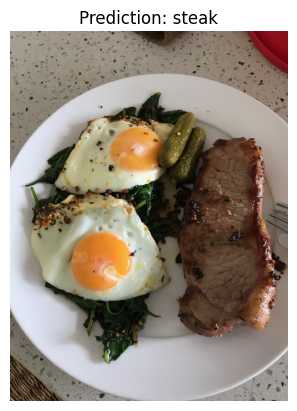

In [ ]:
predict_img(model_6, '03-steak.jpeg', class_names)

1/1 [==============================] - 0s 19ms/step
steak: [[0.6850147]]


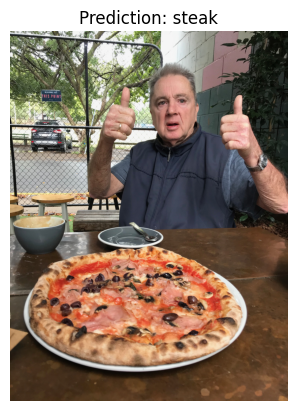

In [ ]:
# bad prediction :(
predict_img(model_6, '03-pizza-dad.jpeg', class_names)

1/1 [==============================] - 0s 19ms/step
pizza: [[0.49382064]]


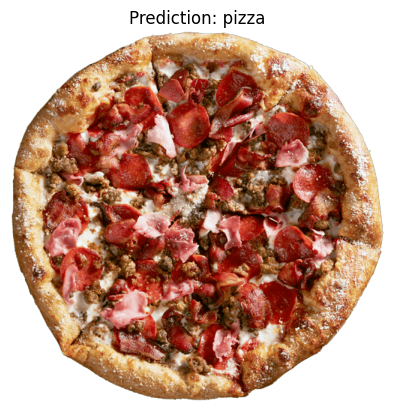

In [ ]:
predict_img(model_6, 'menu-pizza4.jpeg', class_names)

# Multiclass image classification

## Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2023-06-18 11:12:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.4MB/s    in 23s     

2023-06-18 11:12:24 (21.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
  print(f'There are {len(dirnames)} directories, {len(filenames)} files in {dirpath}')

There are 2 directories, 0 files in 10_food_classes_all_data
There are 10 directories, 0 files in 10_food_classes_all_data/train
There are 0 directories, 750 files in 10_food_classes_all_data/train/chicken_curry
There are 0 directories, 750 files in 10_food_classes_all_data/train/ice_cream
There are 0 directories, 750 files in 10_food_classes_all_data/train/sushi
There are 0 directories, 750 files in 10_food_classes_all_data/train/hamburger
There are 0 directories, 750 files in 10_food_classes_all_data/train/fried_rice
There are 0 directories, 750 files in 10_food_classes_all_data/train/chicken_wings
There are 0 directories, 750 files in 10_food_classes_all_data/train/steak
There are 0 directories, 750 files in 10_food_classes_all_data/train/grilled_salmon
There are 0 directories, 750 files in 10_food_classes_all_data/train/ramen
There are 0 directories, 750 files in 10_food_classes_all_data/train/pizza
There are 10 directories, 0 files in 10_food_classes_all_data/test
There are 0 dire

In [ ]:
!ls -la 10_food_classes_all_data/

total 16
drwxr-xr-x  4 root root 4096 Jun 18 11:12 .
drwxr-xr-x  1 root root 4096 Jun 18 11:12 ..
drwxr-xr-x 12 root root 4096 Jun 18 11:12 test
drwxr-xr-x 12 root root 4096 Jun 18 11:12 train


In [ ]:
train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [ ]:
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

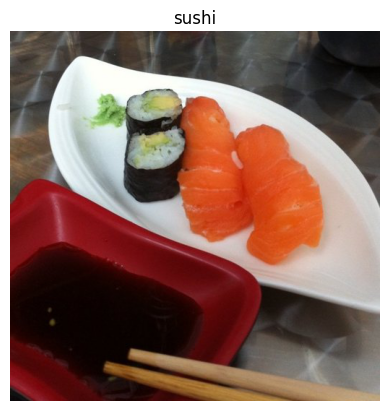

In [ ]:
random_img_class = get_random_img(train_dir, random.choice(class_names), verbose=0)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
train_batch_ammount = len(train_data)
valid_batch_ammount = len(valid_data)

## 10_foods_model_1 - baseline

In [ ]:
food_model_1 = tf.keras.Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [ ]:
food_model_1.compile(
    loss="categorical_crossentropy", # changed to categorical_crossentropy
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
hist_fm1 = food_model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=train_batch_ammount,
    validation_data=valid_data,
    validation_steps=valid_batch_ammount
)

Epoch 1/5
235/235 [==============================] - 67s 237ms/step - loss: 2.1481 - accuracy: 0.2075 - val_loss: 1.9871 - val_accuracy: 0.2820
Epoch 2/5
235/235 [==============================] - 63s 268ms/step - loss: 1.8394 - accuracy: 0.3657 - val_loss: 1.8837 - val_accuracy: 0.3352
Epoch 3/5
235/235 [==============================] - 61s 262ms/step - loss: 1.3653 - accuracy: 0.5420 - val_loss: 2.1416 - val_accuracy: 0.2976
Epoch 4/5
235/235 [==============================] - 54s 230ms/step - loss: 0.6524 - accuracy: 0.7952 - val_loss: 2.8342 - val_accuracy: 0.2840
Epoch 5/5
235/235 [==============================] - 61s 262ms/step - loss: 0.1958 - accuracy: 0.9448 - val_loss: 4.3366 - val_accuracy: 0.2672


In [ ]:
# evaluate
food_model_1.evaluate(valid_data)

79/79 [==============================] - 13s 164ms/step - loss: 4.3366 - accuracy: 0.2672


[4.336618900299072, 0.2671999931335449]

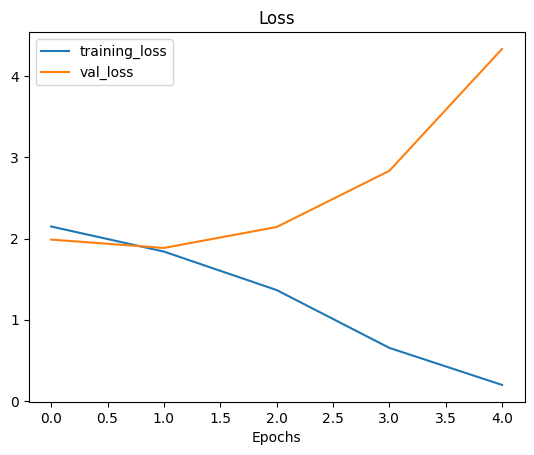

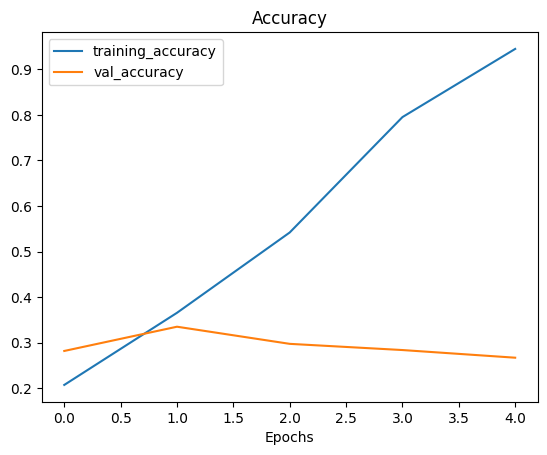

In [ ]:
plot_loss_curves([hist_fm1])

## 10_foods_model_2 - reduce overfiting by simplifying the model

In [ ]:

food_model_2 = tf.keras.Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

In [ ]:
food_model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
hist_fm2 = food_model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=train_batch_ammount,
    validation_data=valid_data,
    validation_steps=valid_batch_ammount
)

Epoch 1/5
235/235 [==============================] - 54s 223ms/step - loss: 2.1754 - accuracy: 0.2221 - val_loss: 1.9971 - val_accuracy: 0.3072
Epoch 2/5
235/235 [==============================] - 60s 254ms/step - loss: 1.8312 - accuracy: 0.3707 - val_loss: 1.9253 - val_accuracy: 0.3212
Epoch 3/5
235/235 [==============================] - 52s 223ms/step - loss: 1.4711 - accuracy: 0.5120 - val_loss: 2.0513 - val_accuracy: 0.3168
Epoch 4/5
235/235 [==============================] - 51s 218ms/step - loss: 0.9833 - accuracy: 0.6852 - val_loss: 2.3027 - val_accuracy: 0.3076
Epoch 5/5
235/235 [==============================] - 52s 221ms/step - loss: 0.5679 - accuracy: 0.8320 - val_loss: 2.6588 - val_accuracy: 0.2920


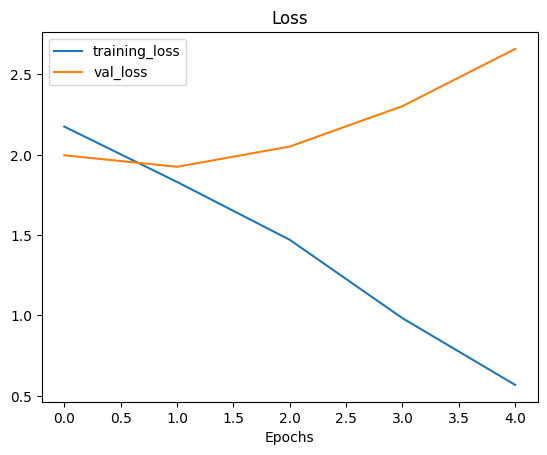

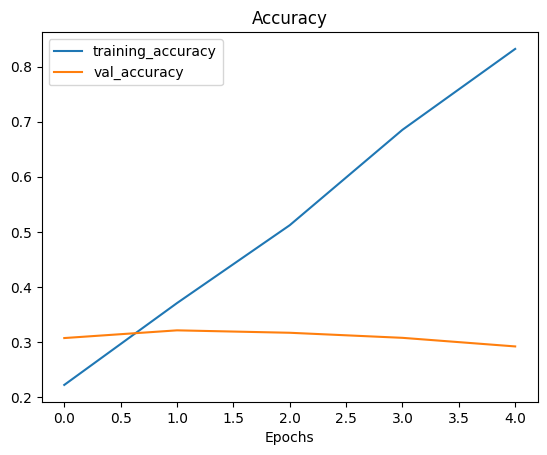

In [ ]:
plot_loss_curves([hist_fm2])

In [ ]:
# params didn't decreased so models are almost the same
food_model_1.summary(), food_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

(None, None)

## Data redone - reducing overfitting by using augmendted data

In [ ]:
# disturb the image to make it less obvious and generalize the look
train_datagen_augmented = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.2, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
    shear_range=0.2, # shear the image
    zoom_range=0.2, # zoom into the image
    width_shift_range=0.2, # shift the image width ways
    height_shift_range=0.2, # shift the image height ways
    horizontal_flip=True # flip the image on the horizontal axis
)

In [ ]:
# rescale to normalize
train_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data
train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

# test images don't need augmentations as they are simulating real life examples
valid_data = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 7500 images belonging to 10 classes.
Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
train_batch_ammount = len(train_data)
valid_batch_ammount = len(valid_data)

## 10_food_model_3 - using new data

In [ ]:
food_model_3 = tf.keras.Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [ ]:
food_model_3.compile(
    loss="categorical_crossentropy", # changed to categorical_crossentropy
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
hist_fm3 = food_model_3.fit(
    train_data_augmented,
    epochs=5,
    steps_per_epoch=train_batch_ammount,
    validation_data=valid_data,
    validation_steps=valid_batch_ammount
)

Epoch 1/5
235/235 [==============================] - 132s 553ms/step - loss: 2.2852 - accuracy: 0.1264 - val_loss: 2.2035 - val_accuracy: 0.1848
Epoch 2/5
235/235 [==============================] - 126s 535ms/step - loss: 2.1811 - accuracy: 0.1992 - val_loss: 2.1078 - val_accuracy: 0.2432
Epoch 3/5
235/235 [==============================] - 126s 537ms/step - loss: 2.1259 - accuracy: 0.2347 - val_loss: 1.9986 - val_accuracy: 0.2956
Epoch 4/5
235/235 [==============================] - 126s 536ms/step - loss: 2.0671 - accuracy: 0.2589 - val_loss: 1.9477 - val_accuracy: 0.3164
Epoch 5/5
235/235 [==============================] - 126s 537ms/step - loss: 2.0307 - accuracy: 0.2795 - val_loss: 1.8992 - val_accuracy: 0.3424


## Predicting new data on trained model

In [ ]:
!wget http://i.pinimg.com/originals/39/b0/00/39b0008a59c93aea26bcb8f44273cc6d.jpg
os.rename('39b0008a59c93aea26bcb8f44273cc6d.jpg', 'ice_cream.jpeg')

--2023-06-18 12:38:01--  http://i.pinimg.com/originals/39/b0/00/39b0008a59c93aea26bcb8f44273cc6d.jpg
Resolving i.pinimg.com (i.pinimg.com)... 199.232.44.84, 2600:1413:1::b832:5592, 2600:1413:1::b832:559a
Connecting to i.pinimg.com (i.pinimg.com)|199.232.44.84|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26018 (25K) [image/jpeg]
Saving to: ‘39b0008a59c93aea26bcb8f44273cc6d.jpg’

39b0008a59c93aea26b 100%[===================>]  25.41K  --.-KB/s    in 0s      

2023-06-18 12:38:02 (124 MB/s) - ‘39b0008a59c93aea26bcb8f44273cc6d.jpg’ saved [26018/26018]



1/1 [==============================] - 0s 19ms/step
ice_cream: [[0.00184469 0.00918058 0.00270231 0.01507793 0.01358133 0.58509105
  0.01681473 0.00649976 0.0506096  0.29859808]]


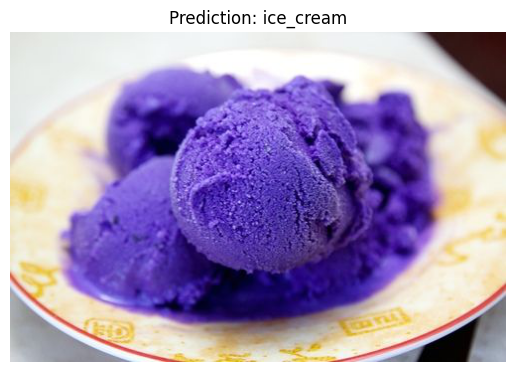

In [ ]:
predict_img(food_model_3, 'ice_cream.jpeg', class_names)

## Saving model

In [ ]:
food_model_3.save('food_model_3')

In [ ]:
loaded_food_model_3 = tf.keras.models.load_model('food_model_3')

In [ ]:
loaded_food_model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [ ]:
loaded_food_model_3.evaluate(valid_data)

79/79 [==============================] - 16s 193ms/step - loss: 1.8992 - accuracy: 0.3424


[1.899166226387024, 0.3424000144004822]